In [1]:
from pathlib import Path
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
from torch.utils import data

import catalyst
from catalyst import dl
from catalyst.utils import metrics, set_global_seed

import matplotlib.pyplot as plt

In [2]:
set_global_seed(42)

In [3]:
from catalyst.utils import (
    create_dataset, create_dataframe, get_dataset_labeling, map_dataframe
)

dataset = create_dataset(dirs=f"./../dataset/train/*", extension="*.jpg")
df = create_dataframe(dataset, columns=["class", "filepath"])

tag_to_label = get_dataset_labeling(df, "class")
class_names = [
    name for name, id_ in sorted(tag_to_label.items(), key=lambda x: x[1])
]

df_with_labels = map_dataframe(
    df, 
    tag_column="class", 
    class_column="label", 
    tag2class=tag_to_label, 
    verbose=False
)
df_with_labels.head()

,class,filepath,label
0,c1d6f6c4,./../dataset/train/c1d6f6c4/bfeddcd4.jpg,0
1,c1d6f6c4,./../dataset/train/c1d6f6c4/bff0a9a0.jpg,0
2,c1d6f6c4,./../dataset/train/c1d6f6c4/bff1d1a4.jpg,0
3,c1d6f6c4,./../dataset/train/c1d6f6c4/bff3363e.jpg,0
4,c1d6f6c4,./../dataset/train/c1d6f6c4/bff4d7b4.jpg,0


In [4]:
from catalyst.utils import split_dataframe_train_test

train_data, valid_data = split_dataframe_train_test(
    df_with_labels, test_size=0.2, random_state=42
)
train_data, valid_data = (
    train_data.to_dict("records"),
    valid_data.to_dict("records"),
)

In [5]:
valid_data[0]

{'class': 'c1d6ff98',
 'filepath': './../dataset/train/c1d6ff98/d26cca6e.jpg',
 'label': 5}

In [6]:
from collections import Counter
print('Class Balance \n')
[print(f'{key} - {value}') for key, value in Counter(df_with_labels['label'].values).items()];

Class Balance 

0 - 901
1 - 901
2 - 901
3 - 901
4 - 901
5 - 901
6 - 901
7 - 858
8 - 901
9 - 901


In [7]:
def show_image(image, figsize=(20, 20), title=None, cmap=None, axis=False):
    """
    show single image
    
    :param image: np.array: image
    :param figsize: (int, int): figure size
    :param title: str: image title
    :param cmap: str: colormap name, for example "Greys_r"
    :param axis: bool: draw axis or not
    :return: None
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    if not axis:
        plt.axis('off')
    plt.imshow(image, cmap)
    plt.show()

In [8]:
def subplot_images(images, n_rows, n_columns, figsize=(20, 20), titles=None, cmap=None, axis=False, layout_pad=(1, 1)):
    """
    show several images
    :param images: list(np.array): list of images
    :param n_rows: int: row number
    :param n_columns: int: column number
    :param figsize: (int, int): figure size
    :param titles: str or list[str]: image titles
    :param cmap: str: colormap name, for example "Greys_r"
    :param axis: bool: draw axis or not
    :param layout_pad: (float, float): padding (width/height) between subplots
    :return: None
    """
    assert len(images) <= n_rows * n_columns
    if titles is None or type(titles) == str:
        titles = [titles] * len(images)
    plt.figure(figsize=figsize)
    for i, image in enumerate(images, start=1):
        plt.subplot(n_rows, n_columns, i, ymargin=0.5, xmargin=0.5)
        plt.title(titles[i-1])
        if not axis:
            plt.axis('off')
        plt.tight_layout(w_pad=layout_pad[0], h_pad=layout_pad[1])
        plt.imshow(image, cmap)
    plt.show()

# Albumentation

In [9]:
import albumentations as albu
import cv2


def pre_transforms(image_size=224):
    return albu.Compose([
        albu.LongestMaxSize(image_size, cv2.INTER_LANCZOS4),
        albu.PadIfNeeded(image_size, image_size, border_mode=cv2.BORDER_CONSTANT)
    ])

def crop_transforms(size=224):
    result = albu.OneOf([albu.Compose(transforms=[albu.RandomCrop(int(size/1.5), int(size/1.5), p=0.2),
                                       pre_transforms()]), 
#            albu.Compose(transforms=[albu.RandomCrop(int(size/2), size//2, p=0.2),
#                                        pre_transforms()]),
           albu.Compose(transforms=[albu.RandomCrop(int(size/1.5), size, p=0.2),
                                       pre_transforms()]),
           albu.Compose(transforms=[albu.RandomCrop(int(size/1.5), size, p=0.2),
                                       pre_transforms()]),
          ], p=0.2)
    return result


def blur_transforms():
    result = [albu.Blur(p=0.1, blur_limit=5),
              albu.MedianBlur(p=0.1, blur_limit=3),
              albu.GaussianBlur(p=0.1, blur_limit=5),
              albu.MotionBlur(p=0.1, blur_limit=5),
              albu.Downscale(p=0.1, scale_min=0.5, scale_max=0.9, interpolation=cv2.INTER_LANCZOS4)]
    return result


def noise_transforms():
    result = [albu.GaussNoise(p=0.1, var_limit=(20, 80)),
              albu.JpegCompression(p=0.1, quality_lower=95),
              albu.IAAAdditiveGaussianNoise(p=0.05)]
    return result


def special_transforms():
    result = [
              albu.CLAHE(clip_limit=2, p=0.1),
              albu.IAASharpen(p=0.1),
              albu.IAAEmboss(p=0.1)
              ]
    return result


def rotate_transforms():
    result = [albu.Rotate(15, p=0.3),
              albu.ShiftScaleRotate(shift_limit=0.1025, scale_limit=0.1, rotate_limit=15, p=0.1)]
    return result

def flip_transforms():
    result = [albu.HorizontalFlip(p=0.25),
              albu.VerticalFlip(p=0.1)]
    return result


def distortiot_transforms():
    result = [albu.GridDistortion(p=0.1),
              albu.IAAPiecewiseAffine(p=0.05),
              albu.OpticalDistortion(p=0.05, distort_limit=0.3, shift_limit=0.5),
              ]
    return result


def color_transforms():
    result = [albu.RandomBrightness(p=0.1),
              albu.RandomContrast(p=0.1),
              albu.RandomGamma(p=0.1),
              albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
              ]
    return result


def post_transforms():
    return [albu.Normalize(mean=0, std=1)]


def compose(transforms_to_compose):
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result


hard_transforms = compose([blur_transforms(),
                           crop_transforms(),
                           flip_transforms(),
                           noise_transforms(),
                           special_transforms(),
                           rotate_transforms(),
                           distortiot_transforms(),
                           color_transforms()])

train_transforms = compose([
    pre_transforms(),
    hard_transforms,
    post_transforms(),
])

valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms])

In [10]:
from typing import List, Any, Tuple, Dict
class ClassificationDataset(data.Dataset):
    def __init__(self, dataset: List[Dict[str, Any]], n_classes: int, transforms=None, label_smoothing=None):
        self.dataset = dataset
        self.transforms = transforms
        self.n_classes = n_classes
        self.label_smoothing = label_smoothing

    def __len__(self):
        return len(self.dataset)

    def _get_target(self, label):
        target_vector = torch.zeros(self.n_classes)
        if self.label_smoothing is None:
            target_vector[label] = 1
            return target_vector
        else:
            target_vector = target_vector + self.label_smoothing * 1 / (self.n_classes - 1)
            target_vector[label] = 1 - self.label_smoothing
            return target_vector

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        :param idx: int: index of elem to return
        :return: dict: dict of image and target
        """
        image_path = self.dataset[idx]['filepath']
        image_id = image_path.split("/")[-1].split(".")[0]
        test_flag = 'label' not in list(self.dataset[idx].keys())
        if not test_flag:
            label = self.dataset[idx]['label']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = {"image": image, 'image_id': image_id}
        if self.transforms is not None:
            result = self.transforms(**result)
        result['image'] = torch.tensor(np.transpose(result['image'], axes=(2, 0, 1))).type(torch.FloatTensor)
        if not test_flag:
            result['target_one_hot'] = self._get_target(label)
            result['target'] = torch.tensor([label])
        return result

## Augmantation examples

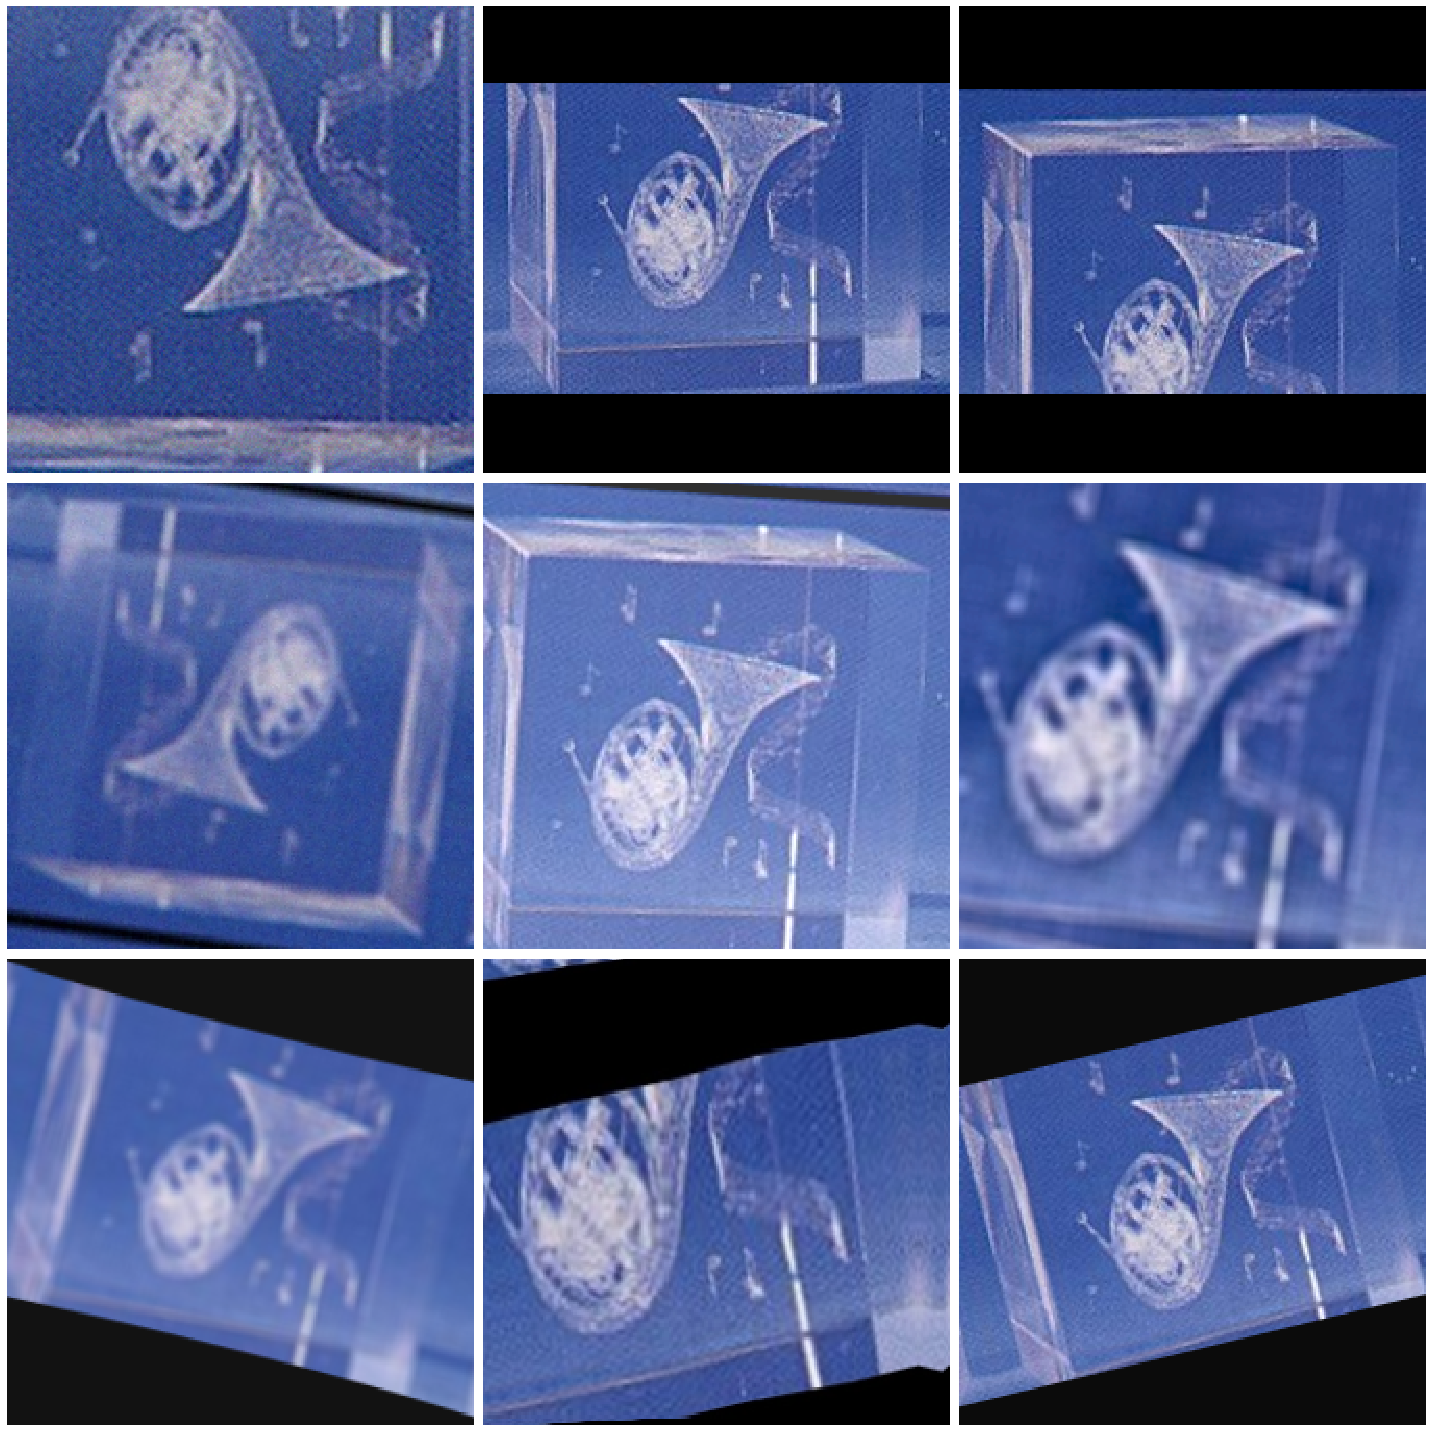

In [11]:
n_classes = len(tag_to_label)

show_dataset = ClassificationDataset(train_data, n_classes, show_transforms)

images = [np.transpose(show_dataset[20]['image'].numpy().astype(np.uint8), axes=(1, 2, 0)) for _ in range(9)]

subplot_images(images, 3, 3)

In [12]:
batch_size = 256
num_workers = 0

train_dataset = ClassificationDataset(train_data, n_classes, train_transforms, 0.05)
valid_dataset = ClassificationDataset(valid_data, n_classes, valid_transforms)


train_loader = data.DataLoader(train_dataset, batch_size=batch_size,
                               shuffle=True, drop_last=True, num_workers=num_workers)

valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size,
                               shuffle=False, drop_last=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [13]:
batch = next(iter(train_loader))

# Model

In [14]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.linear = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512*block.expansion, num_classes),
        )
#         self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
        out = self.layer4(out)
#         print('before avg_pool2d', out.shape)
#         out = F.avg_pool2d(out, 4)
#         print('after avg_pool2d', out.shape)
#         out = out.view(out.size(0), -1)
#         print('before linear', out.shape)
        out = self.linear(out)
        return out

In [15]:
model = ResNet(BasicBlock, [2, 2, 2, 2])

In [16]:
output = model(batch['image'])
print(output.shape)

torch.Size([256, 10])


In [17]:
batch['target_one_hot'][1]

tensor([0.9500, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
        0.0056])

In [36]:
from catalyst.dl import SupervisedRunner

# device = torch.device('cpu') 
device = torch.device('cuda:0')

In [37]:
runner = SupervisedRunner(model, device, input_key='image',
                          output_key='logits', input_target_key=['target', 'target_one_hot'])

In [38]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.005

base_optimizer = RAdam(model.parameters(), lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=5, mode='max')


In [39]:
from catalyst.dl.callbacks import (
    AUCCallback, F1ScoreCallback, CriterionCallback, ConfusionMatrixCallback, AccuracyCallback,
    EarlyStoppingCallback, MetricAggregationCallback, MetricCallback, ConfusionMatrixCallback, OptimizerCallback
)

from catalyst.contrib.nn.criterion.focal import FocalLossMultiClass, FocalLossBinary

criterion = {'focal_class': FocalLossBinary()}

callbacks = [
    CriterionCallback(criterion_key='focal_class',
                      input_key='target_one_hot',
                      output_key='logits',
                      prefix='loss'),
    AUCCallback(input_key="target_one_hot",
                output_key="logits",
                prefix='auc_class'),
    AccuracyCallback(input_key='target',
                     output_key='logits',
                     prefix='accuracy',
                     num_classes=10),
    ConfusionMatrixCallback(input_key='target_one_hot',
                            output_key='logits',
                            num_classes=n_classes),
    OptimizerCallback(metric_key='loss', accumulation_steps=1),
    EarlyStoppingCallback(patience=10, metric='accuracy01', minimize=False),
]

In [40]:
log_path = './../logs/label_smoothing_005_experiment_2' 

In [41]:
runner.train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    loaders=loaders,
    logdir=log_path,
    num_epochs=100,
    verbose=False,
    load_best_on_end=True,
    callbacks=callbacks,
    main_metric='accuracy01',
    minimize_metric=False
)

[2020-10-16 20:11:52,469] 
1/100 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/100 * Epoch 1 (train): accuracy01=0.9498 | accuracy03=0.9920 | accuracy05=0.9985 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0039
1/100 * Epoch 1 (valid): accuracy01=0.8891 | accuracy03=0.9716 | accuracy05=0.9905 | auc_class/class_00=0.9859 | auc_class/class_01=0.9880 | auc_class/class_02=0.9876 | auc_class/class_03=0.9960 | auc_class/class_04=0.9888 | auc_class/class_05=0.9895 | auc_class/class_06=0.9902 | auc_class/class_07=0.9778 | auc_class/class_08=0.9992 | auc_class/class_09=0.9936 | auc_class/mean=0.9897 | loss=0.0069


I1016 20:11:52.469237 139872244295424 logging.py:164] 
1/100 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/100 * Epoch 1 (train): accuracy01=0.9498 | accuracy03=0.9920 | accuracy05=0.9985 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0039
1/100 * Epoch 1 (valid): accuracy01=0.8891 | accuracy03=0.9716 | accuracy05=0.9905 | auc_class/class_00=0.9859 | auc_class/class_01=0.9880 | auc_class/class_02=0.9876 | auc_class/class_03=0.9960 | auc_class/class_04=0.9888 | auc_class/class_05=0.9895 | auc_class/class_06=0.9902 | auc_class/class_07=0.9778 | auc_class/class_08=0.9992 | auc_class/class_09=0.9936 | auc_class/mean=0.9897 | loss=0.0069


[2020-10-16 20:13:31,297] 
2/100 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/100 * Epoch 2 (train): accuracy01=0.9421 | accuracy03=0.9904 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0042
2/100 * Epoch 2 (valid): accuracy01=0.8902 | accuracy03=0.9716 | accuracy05=0.9894 | auc_class/class_00=0.9855 | auc_class/class_01=0.9886 | auc_class/class_02=0.9889 | auc_class/class_03=0.9959 | auc_class/class_04=0.9883 | auc_class/class_05=0.9876 | auc_class/class_06=0.9924 | auc_class/class_07=0.9772 | auc_class/class_08=0.9992 | auc_class/class_09=0.9939 | auc_class/mean=0.9897 | loss=0.0067


I1016 20:13:31.297246 139872244295424 logging.py:164] 
2/100 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/100 * Epoch 2 (train): accuracy01=0.9421 | accuracy03=0.9904 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0042
2/100 * Epoch 2 (valid): accuracy01=0.8902 | accuracy03=0.9716 | accuracy05=0.9894 | auc_class/class_00=0.9855 | auc_class/class_01=0.9886 | auc_class/class_02=0.9889 | auc_class/class_03=0.9959 | auc_class/class_04=0.9883 | auc_class/class_05=0.9876 | auc_class/class_06=0.9924 | auc_class/class_07=0.9772 | auc_class/class_08=0.9992 | auc_class/class_09=0.9939 | auc_class/mean=0.9897 | loss=0.0067


[2020-10-16 20:15:10,480] 
3/100 * Epoch 3 (_base): lr=0.0005 | momentum=0.9000
3/100 * Epoch 3 (train): accuracy01=0.9457 | accuracy03=0.9897 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0041
3/100 * Epoch 3 (valid): accuracy01=0.8863 | accuracy03=0.9649 | accuracy05=0.9877 | auc_class/class_00=0.9844 | auc_class/class_01=0.9879 | auc_class/class_02=0.9874 | auc_class/class_03=0.9973 | auc_class/class_04=0.9882 | auc_class/class_05=0.9870 | auc_class/class_06=0.9875 | auc_class/class_07=0.9789 | auc_class/class_08=0.9991 | auc_class/class_09=0.9918 | auc_class/mean=0.9890 | loss=0.0074


I1016 20:15:10.480752 139872244295424 logging.py:164] 
3/100 * Epoch 3 (_base): lr=0.0005 | momentum=0.9000
3/100 * Epoch 3 (train): accuracy01=0.9457 | accuracy03=0.9897 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0041
3/100 * Epoch 3 (valid): accuracy01=0.8863 | accuracy03=0.9649 | accuracy05=0.9877 | auc_class/class_00=0.9844 | auc_class/class_01=0.9879 | auc_class/class_02=0.9874 | auc_class/class_03=0.9973 | auc_class/class_04=0.9882 | auc_class/class_05=0.9870 | auc_class/class_06=0.9875 | auc_class/class_07=0.9789 | auc_class/class_08=0.9991 | auc_class/class_09=0.9918 | auc_class/mean=0.9890 | loss=0.0074


[2020-10-16 20:16:49,165] 
4/100 * Epoch 4 (_base): lr=0.0005 | momentum=0.9000
4/100 * Epoch 4 (train): accuracy01=0.9468 | accuracy03=0.9915 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0041
4/100 * Epoch 4 (valid): accuracy01=0.8846 | accuracy03=0.9699 | accuracy05=0.9916 | auc_class/class_00=0.9863 | auc_class/class_01=0.9885 | auc_class/class_02=0.9887 | auc_class/class_03=0.9965 | auc_class/class_04=0.9888 | auc_class/class_05=0.9854 | auc_class/class_06=0.9911 | auc_class/class_07=0.9749 | auc_class/class_08=0.9991 | auc_class/class_09=0.9930 | auc_class/mean=0.9892 | loss=0.0074


I1016 20:16:49.165472 139872244295424 logging.py:164] 
4/100 * Epoch 4 (_base): lr=0.0005 | momentum=0.9000
4/100 * Epoch 4 (train): accuracy01=0.9468 | accuracy03=0.9915 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0041
4/100 * Epoch 4 (valid): accuracy01=0.8846 | accuracy03=0.9699 | accuracy05=0.9916 | auc_class/class_00=0.9863 | auc_class/class_01=0.9885 | auc_class/class_02=0.9887 | auc_class/class_03=0.9965 | auc_class/class_04=0.9888 | auc_class/class_05=0.9854 | auc_class/class_06=0.9911 | auc_class/class_07=0.9749 | auc_class/class_08=0.9991 | auc_class/class_09=0.9930 | auc_class/mean=0.9892 | loss=0.0074


[2020-10-16 20:18:28,596] 
5/100 * Epoch 5 (_base): lr=0.0005 | momentum=0.9000
5/100 * Epoch 5 (train): accuracy01=0.9407 | accuracy03=0.9909 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0043
5/100 * Epoch 5 (valid): accuracy01=0.8562 | accuracy03=0.9599 | accuracy05=0.9877 | auc_class/class_00=0.9791 | auc_class/class_01=0.9870 | auc_class/class_02=0.9854 | auc_class/class_03=0.9942 | auc_class/class_04=0.9762 | auc_class/class_05=0.9863 | auc_class/class_06=0.9911 | auc_class/class_07=0.9677 | auc_class/class_08=0.9985 | auc_class/class_09=0.9917 | auc_class/mean=0.9857 | loss=0.0095


I1016 20:18:28.596356 139872244295424 logging.py:164] 
5/100 * Epoch 5 (_base): lr=0.0005 | momentum=0.9000
5/100 * Epoch 5 (train): accuracy01=0.9407 | accuracy03=0.9909 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0043
5/100 * Epoch 5 (valid): accuracy01=0.8562 | accuracy03=0.9599 | accuracy05=0.9877 | auc_class/class_00=0.9791 | auc_class/class_01=0.9870 | auc_class/class_02=0.9854 | auc_class/class_03=0.9942 | auc_class/class_04=0.9762 | auc_class/class_05=0.9863 | auc_class/class_06=0.9911 | auc_class/class_07=0.9677 | auc_class/class_08=0.9985 | auc_class/class_09=0.9917 | auc_class/mean=0.9857 | loss=0.0095


[2020-10-16 20:20:08,049] 
6/100 * Epoch 6 (_base): lr=0.0005 | momentum=0.9000
6/100 * Epoch 6 (train): accuracy01=0.9441 | accuracy03=0.9912 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0043
6/100 * Epoch 6 (valid): accuracy01=0.8640 | accuracy03=0.9643 | accuracy05=0.9872 | auc_class/class_00=0.9822 | auc_class/class_01=0.9875 | auc_class/class_02=0.9876 | auc_class/class_03=0.9966 | auc_class/class_04=0.9879 | auc_class/class_05=0.9866 | auc_class/class_06=0.9926 | auc_class/class_07=0.9710 | auc_class/class_08=0.9990 | auc_class/class_09=0.9913 | auc_class/mean=0.9882 | loss=0.0086


I1016 20:20:08.049808 139872244295424 logging.py:164] 
6/100 * Epoch 6 (_base): lr=0.0005 | momentum=0.9000
6/100 * Epoch 6 (train): accuracy01=0.9441 | accuracy03=0.9912 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0043
6/100 * Epoch 6 (valid): accuracy01=0.8640 | accuracy03=0.9643 | accuracy05=0.9872 | auc_class/class_00=0.9822 | auc_class/class_01=0.9875 | auc_class/class_02=0.9876 | auc_class/class_03=0.9966 | auc_class/class_04=0.9879 | auc_class/class_05=0.9866 | auc_class/class_06=0.9926 | auc_class/class_07=0.9710 | auc_class/class_08=0.9990 | auc_class/class_09=0.9913 | auc_class/mean=0.9882 | loss=0.0086


[2020-10-16 20:21:46,515] 
7/100 * Epoch 7 (_base): lr=0.0005 | momentum=0.9000
7/100 * Epoch 7 (train): accuracy01=0.9435 | accuracy03=0.9895 | accuracy05=0.9971 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0042
7/100 * Epoch 7 (valid): accuracy01=0.8679 | accuracy03=0.9688 | accuracy05=0.9866 | auc_class/class_00=0.9848 | auc_class/class_01=0.9888 | auc_class/class_02=0.9888 | auc_class/class_03=0.9963 | auc_class/class_04=0.9872 | auc_class/class_05=0.9845 | auc_class/class_06=0.9909 | auc_class/class_07=0.9761 | auc_class/class_08=0.9987 | auc_class/class_09=0.9882 | auc_class/mean=0.9884 | loss=0.0084


I1016 20:21:46.515768 139872244295424 logging.py:164] 
7/100 * Epoch 7 (_base): lr=0.0005 | momentum=0.9000
7/100 * Epoch 7 (train): accuracy01=0.9435 | accuracy03=0.9895 | accuracy05=0.9971 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0042
7/100 * Epoch 7 (valid): accuracy01=0.8679 | accuracy03=0.9688 | accuracy05=0.9866 | auc_class/class_00=0.9848 | auc_class/class_01=0.9888 | auc_class/class_02=0.9888 | auc_class/class_03=0.9963 | auc_class/class_04=0.9872 | auc_class/class_05=0.9845 | auc_class/class_06=0.9909 | auc_class/class_07=0.9761 | auc_class/class_08=0.9987 | auc_class/class_09=0.9882 | auc_class/mean=0.9884 | loss=0.0084


[2020-10-16 20:23:24,341] 
8/100 * Epoch 8 (_base): lr=0.0001 | momentum=0.9000
8/100 * Epoch 8 (train): accuracy01=0.9459 | accuracy03=0.9905 | accuracy05=0.9965 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0042
8/100 * Epoch 8 (valid): accuracy01=0.8634 | accuracy03=0.9632 | accuracy05=0.9866 | auc_class/class_00=0.9864 | auc_class/class_01=0.9827 | auc_class/class_02=0.9866 | auc_class/class_03=0.9962 | auc_class/class_04=0.9864 | auc_class/class_05=0.9870 | auc_class/class_06=0.9927 | auc_class/class_07=0.9764 | auc_class/class_08=0.9985 | auc_class/class_09=0.9885 | auc_class/mean=0.9882 | loss=0.0080


I1016 20:23:24.341005 139872244295424 logging.py:164] 
8/100 * Epoch 8 (_base): lr=0.0001 | momentum=0.9000
8/100 * Epoch 8 (train): accuracy01=0.9459 | accuracy03=0.9905 | accuracy05=0.9965 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0042
8/100 * Epoch 8 (valid): accuracy01=0.8634 | accuracy03=0.9632 | accuracy05=0.9866 | auc_class/class_00=0.9864 | auc_class/class_01=0.9827 | auc_class/class_02=0.9866 | auc_class/class_03=0.9962 | auc_class/class_04=0.9864 | auc_class/class_05=0.9870 | auc_class/class_06=0.9927 | auc_class/class_07=0.9764 | auc_class/class_08=0.9985 | auc_class/class_09=0.9885 | auc_class/mean=0.9882 | loss=0.0080


[2020-10-16 20:25:04,071] 
9/100 * Epoch 9 (_base): lr=0.0001 | momentum=0.9000
9/100 * Epoch 9 (train): accuracy01=0.9494 | accuracy03=0.9915 | accuracy05=0.9968 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0039
9/100 * Epoch 9 (valid): accuracy01=0.8885 | accuracy03=0.9716 | accuracy05=0.9889 | auc_class/class_00=0.9853 | auc_class/class_01=0.9885 | auc_class/class_02=0.9892 | auc_class/class_03=0.9963 | auc_class/class_04=0.9897 | auc_class/class_05=0.9881 | auc_class/class_06=0.9919 | auc_class/class_07=0.9793 | auc_class/class_08=0.9989 | auc_class/class_09=0.9917 | auc_class/mean=0.9899 | loss=0.0068


I1016 20:25:04.071228 139872244295424 logging.py:164] 
9/100 * Epoch 9 (_base): lr=0.0001 | momentum=0.9000
9/100 * Epoch 9 (train): accuracy01=0.9494 | accuracy03=0.9915 | accuracy05=0.9968 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0039
9/100 * Epoch 9 (valid): accuracy01=0.8885 | accuracy03=0.9716 | accuracy05=0.9889 | auc_class/class_00=0.9853 | auc_class/class_01=0.9885 | auc_class/class_02=0.9892 | auc_class/class_03=0.9963 | auc_class/class_04=0.9897 | auc_class/class_05=0.9881 | auc_class/class_06=0.9919 | auc_class/class_07=0.9793 | auc_class/class_08=0.9989 | auc_class/class_09=0.9917 | auc_class/mean=0.9899 | loss=0.0068


[2020-10-16 20:26:43,736] 
10/100 * Epoch 10 (_base): lr=0.0001 | momentum=0.9000
10/100 * Epoch 10 (train): accuracy01=0.9531 | accuracy03=0.9918 | accuracy05=0.9975 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0038
10/100 * Epoch 10 (valid): accuracy01=0.8779 | accuracy03=0.9688 | accuracy05=0.9894 | auc_class/class_00=0.9870 | auc_class/class_01=0.9860 | auc_class/class_02=0.9907 | auc_class/class_03=0.9963 | auc_class/class_04=0.9873 | auc_class/class_05=0.9865 | auc_class/class_06=0.9926 | auc_class/class_07=0.9755 | auc_class/class_08=0.9990 | auc_class/class_09=0.9917 | auc_class/mean=0.9893 | loss=0.0075


I1016 20:26:43.736357 139872244295424 logging.py:164] 
10/100 * Epoch 10 (_base): lr=0.0001 | momentum=0.9000
10/100 * Epoch 10 (train): accuracy01=0.9531 | accuracy03=0.9918 | accuracy05=0.9975 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0038
10/100 * Epoch 10 (valid): accuracy01=0.8779 | accuracy03=0.9688 | accuracy05=0.9894 | auc_class/class_00=0.9870 | auc_class/class_01=0.9860 | auc_class/class_02=0.9907 | auc_class/class_03=0.9963 | auc_class/class_04=0.9873 | auc_class/class_05=0.9865 | auc_class/class_06=0.9926 | auc_class/class_07=0.9755 | auc_class/class_08=0.9990 | auc_class/class_09=0.9917 | auc_class/mean=0.9893 | loss=0.0075


[2020-10-16 20:28:24,217] 
11/100 * Epoch 11 (_base): lr=0.0001 | momentum=0.9000
11/100 * Epoch 11 (train): accuracy01=0.9611 | accuracy03=0.9947 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0035
11/100 * Epoch 11 (valid): accuracy01=0.8913 | accuracy03=0.9677 | accuracy05=0.9877 | auc_class/class_00=0.9845 | auc_class/class_01=0.9885 | auc_class/class_02=0.9896 | auc_class/class_03=0.9964 | auc_class/class_04=0.9891 | auc_class/class_05=0.9884 | auc_class/class_06=0.9911 | auc_class/class_07=0.9789 | auc_class/class_08=0.9991 | auc_class/class_09=0.9922 | auc_class/mean=0.9898 | loss=0.0070


I1016 20:28:24.217481 139872244295424 logging.py:164] 
11/100 * Epoch 11 (_base): lr=0.0001 | momentum=0.9000
11/100 * Epoch 11 (train): accuracy01=0.9611 | accuracy03=0.9947 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0035
11/100 * Epoch 11 (valid): accuracy01=0.8913 | accuracy03=0.9677 | accuracy05=0.9877 | auc_class/class_00=0.9845 | auc_class/class_01=0.9885 | auc_class/class_02=0.9896 | auc_class/class_03=0.9964 | auc_class/class_04=0.9891 | auc_class/class_05=0.9884 | auc_class/class_06=0.9911 | auc_class/class_07=0.9789 | auc_class/class_08=0.9991 | auc_class/class_09=0.9922 | auc_class/mean=0.9898 | loss=0.0070


[2020-10-16 20:30:02,292] 
12/100 * Epoch 12 (_base): lr=0.0001 | momentum=0.9000
12/100 * Epoch 12 (train): accuracy01=0.9573 | accuracy03=0.9934 | accuracy05=0.9983 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0035
12/100 * Epoch 12 (valid): accuracy01=0.8952 | accuracy03=0.9732 | accuracy05=0.9900 | auc_class/class_00=0.9847 | auc_class/class_01=0.9896 | auc_class/class_02=0.9898 | auc_class/class_03=0.9964 | auc_class/class_04=0.9890 | auc_class/class_05=0.9867 | auc_class/class_06=0.9913 | auc_class/class_07=0.9792 | auc_class/class_08=0.9991 | auc_class/class_09=0.9933 | auc_class/mean=0.9899 | loss=0.0068


I1016 20:30:02.292733 139872244295424 logging.py:164] 
12/100 * Epoch 12 (_base): lr=0.0001 | momentum=0.9000
12/100 * Epoch 12 (train): accuracy01=0.9573 | accuracy03=0.9934 | accuracy05=0.9983 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0035
12/100 * Epoch 12 (valid): accuracy01=0.8952 | accuracy03=0.9732 | accuracy05=0.9900 | auc_class/class_00=0.9847 | auc_class/class_01=0.9896 | auc_class/class_02=0.9898 | auc_class/class_03=0.9964 | auc_class/class_04=0.9890 | auc_class/class_05=0.9867 | auc_class/class_06=0.9913 | auc_class/class_07=0.9792 | auc_class/class_08=0.9991 | auc_class/class_09=0.9933 | auc_class/mean=0.9899 | loss=0.0068


[2020-10-16 20:31:41,224] 
13/100 * Epoch 13 (_base): lr=0.0001 | momentum=0.9000
13/100 * Epoch 13 (train): accuracy01=0.9542 | accuracy03=0.9925 | accuracy05=0.9989 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0037
13/100 * Epoch 13 (valid): accuracy01=0.8785 | accuracy03=0.9682 | accuracy05=0.9911 | auc_class/class_00=0.9856 | auc_class/class_01=0.9892 | auc_class/class_02=0.9902 | auc_class/class_03=0.9969 | auc_class/class_04=0.9896 | auc_class/class_05=0.9832 | auc_class/class_06=0.9906 | auc_class/class_07=0.9765 | auc_class/class_08=0.9991 | auc_class/class_09=0.9923 | auc_class/mean=0.9893 | loss=0.0076


I1016 20:31:41.224639 139872244295424 logging.py:164] 
13/100 * Epoch 13 (_base): lr=0.0001 | momentum=0.9000
13/100 * Epoch 13 (train): accuracy01=0.9542 | accuracy03=0.9925 | accuracy05=0.9989 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0037
13/100 * Epoch 13 (valid): accuracy01=0.8785 | accuracy03=0.9682 | accuracy05=0.9911 | auc_class/class_00=0.9856 | auc_class/class_01=0.9892 | auc_class/class_02=0.9902 | auc_class/class_03=0.9969 | auc_class/class_04=0.9896 | auc_class/class_05=0.9832 | auc_class/class_06=0.9906 | auc_class/class_07=0.9765 | auc_class/class_08=0.9991 | auc_class/class_09=0.9923 | auc_class/mean=0.9893 | loss=0.0076


[2020-10-16 20:33:20,935] 
14/100 * Epoch 14 (_base): lr=0.0001 | momentum=0.9000
14/100 * Epoch 14 (train): accuracy01=0.9548 | accuracy03=0.9932 | accuracy05=0.9986 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0035
14/100 * Epoch 14 (valid): accuracy01=0.8952 | accuracy03=0.9716 | accuracy05=0.9922 | auc_class/class_00=0.9860 | auc_class/class_01=0.9890 | auc_class/class_02=0.9907 | auc_class/class_03=0.9966 | auc_class/class_04=0.9890 | auc_class/class_05=0.9873 | auc_class/class_06=0.9907 | auc_class/class_07=0.9781 | auc_class/class_08=0.9993 | auc_class/class_09=0.9932 | auc_class/mean=0.9900 | loss=0.0068


I1016 20:33:20.935437 139872244295424 logging.py:164] 
14/100 * Epoch 14 (_base): lr=0.0001 | momentum=0.9000
14/100 * Epoch 14 (train): accuracy01=0.9548 | accuracy03=0.9932 | accuracy05=0.9986 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0035
14/100 * Epoch 14 (valid): accuracy01=0.8952 | accuracy03=0.9716 | accuracy05=0.9922 | auc_class/class_00=0.9860 | auc_class/class_01=0.9890 | auc_class/class_02=0.9907 | auc_class/class_03=0.9966 | auc_class/class_04=0.9890 | auc_class/class_05=0.9873 | auc_class/class_06=0.9907 | auc_class/class_07=0.9781 | auc_class/class_08=0.9993 | auc_class/class_09=0.9932 | auc_class/mean=0.9900 | loss=0.0068


[2020-10-16 20:34:59,752] 
15/100 * Epoch 15 (_base): lr=0.0001 | momentum=0.9000
15/100 * Epoch 15 (train): accuracy01=0.9565 | accuracy03=0.9936 | accuracy05=0.9990 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0034
15/100 * Epoch 15 (valid): accuracy01=0.8924 | accuracy03=0.9705 | accuracy05=0.9900 | auc_class/class_00=0.9877 | auc_class/class_01=0.9896 | auc_class/class_02=0.9887 | auc_class/class_03=0.9970 | auc_class/class_04=0.9879 | auc_class/class_05=0.9863 | auc_class/class_06=0.9901 | auc_class/class_07=0.9778 | auc_class/class_08=0.9992 | auc_class/class_09=0.9931 | auc_class/mean=0.9897 | loss=0.0069


I1016 20:34:59.752216 139872244295424 logging.py:164] 
15/100 * Epoch 15 (_base): lr=0.0001 | momentum=0.9000
15/100 * Epoch 15 (train): accuracy01=0.9565 | accuracy03=0.9936 | accuracy05=0.9990 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0034
15/100 * Epoch 15 (valid): accuracy01=0.8924 | accuracy03=0.9705 | accuracy05=0.9900 | auc_class/class_00=0.9877 | auc_class/class_01=0.9896 | auc_class/class_02=0.9887 | auc_class/class_03=0.9970 | auc_class/class_04=0.9879 | auc_class/class_05=0.9863 | auc_class/class_06=0.9901 | auc_class/class_07=0.9778 | auc_class/class_08=0.9992 | auc_class/class_09=0.9931 | auc_class/mean=0.9897 | loss=0.0069


[2020-10-16 20:36:39,407] 
16/100 * Epoch 16 (_base): lr=0.0001 | momentum=0.9000
16/100 * Epoch 16 (train): accuracy01=0.9601 | accuracy03=0.9946 | accuracy05=0.9992 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0033
16/100 * Epoch 16 (valid): accuracy01=0.8907 | accuracy03=0.9693 | accuracy05=0.9894 | auc_class/class_00=0.9845 | auc_class/class_01=0.9902 | auc_class/class_02=0.9899 | auc_class/class_03=0.9960 | auc_class/class_04=0.9899 | auc_class/class_05=0.9854 | auc_class/class_06=0.9912 | auc_class/class_07=0.9772 | auc_class/class_08=0.9992 | auc_class/class_09=0.9934 | auc_class/mean=0.9897 | loss=0.0070


I1016 20:36:39.407224 139872244295424 logging.py:164] 
16/100 * Epoch 16 (_base): lr=0.0001 | momentum=0.9000
16/100 * Epoch 16 (train): accuracy01=0.9601 | accuracy03=0.9946 | accuracy05=0.9992 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0033
16/100 * Epoch 16 (valid): accuracy01=0.8907 | accuracy03=0.9693 | accuracy05=0.9894 | auc_class/class_00=0.9845 | auc_class/class_01=0.9902 | auc_class/class_02=0.9899 | auc_class/class_03=0.9960 | auc_class/class_04=0.9899 | auc_class/class_05=0.9854 | auc_class/class_06=0.9912 | auc_class/class_07=0.9772 | auc_class/class_08=0.9992 | auc_class/class_09=0.9934 | auc_class/mean=0.9897 | loss=0.0070


[2020-10-16 20:38:17,432] 
17/100 * Epoch 17 (_base): lr=0.0001 | momentum=0.9000
17/100 * Epoch 17 (train): accuracy01=0.9602 | accuracy03=0.9940 | accuracy05=0.9985 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0033
17/100 * Epoch 17 (valid): accuracy01=0.8907 | accuracy03=0.9721 | accuracy05=0.9911 | auc_class/class_00=0.9862 | auc_class/class_01=0.9903 | auc_class/class_02=0.9894 | auc_class/class_03=0.9961 | auc_class/class_04=0.9894 | auc_class/class_05=0.9883 | auc_class/class_06=0.9910 | auc_class/class_07=0.9780 | auc_class/class_08=0.9993 | auc_class/class_09=0.9933 | auc_class/mean=0.9901 | loss=0.0070


I1016 20:38:17.432526 139872244295424 logging.py:164] 
17/100 * Epoch 17 (_base): lr=0.0001 | momentum=0.9000
17/100 * Epoch 17 (train): accuracy01=0.9602 | accuracy03=0.9940 | accuracy05=0.9985 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0033
17/100 * Epoch 17 (valid): accuracy01=0.8907 | accuracy03=0.9721 | accuracy05=0.9911 | auc_class/class_00=0.9862 | auc_class/class_01=0.9903 | auc_class/class_02=0.9894 | auc_class/class_03=0.9961 | auc_class/class_04=0.9894 | auc_class/class_05=0.9883 | auc_class/class_06=0.9910 | auc_class/class_07=0.9780 | auc_class/class_08=0.9993 | auc_class/class_09=0.9933 | auc_class/mean=0.9901 | loss=0.0070


[2020-10-16 20:39:54,903] 
18/100 * Epoch 18 (_base): lr=3.125e-05 | momentum=0.9000
18/100 * Epoch 18 (train): accuracy01=0.9569 | accuracy03=0.9933 | accuracy05=0.9983 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0034
18/100 * Epoch 18 (valid): accuracy01=0.8807 | accuracy03=0.9688 | accuracy05=0.9900 | auc_class/class_00=0.9852 | auc_class/class_01=0.9903 | auc_class/class_02=0.9880 | auc_class/class_03=0.9961 | auc_class/class_04=0.9878 | auc_class/class_05=0.9904 | auc_class/class_06=0.9908 | auc_class/class_07=0.9776 | auc_class/class_08=0.9991 | auc_class/class_09=0.9941 | auc_class/mean=0.9899 | loss=0.0076


I1016 20:39:54.903413 139872244295424 logging.py:164] 
18/100 * Epoch 18 (_base): lr=3.125e-05 | momentum=0.9000
18/100 * Epoch 18 (train): accuracy01=0.9569 | accuracy03=0.9933 | accuracy05=0.9983 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0034
18/100 * Epoch 18 (valid): accuracy01=0.8807 | accuracy03=0.9688 | accuracy05=0.9900 | auc_class/class_00=0.9852 | auc_class/class_01=0.9903 | auc_class/class_02=0.9880 | auc_class/class_03=0.9961 | auc_class/class_04=0.9878 | auc_class/class_05=0.9904 | auc_class/class_06=0.9908 | auc_class/class_07=0.9776 | auc_class/class_08=0.9991 | auc_class/class_09=0.9941 | auc_class/mean=0.9899 | loss=0.0076


[2020-10-16 20:41:34,829] 
19/100 * Epoch 19 (_base): lr=3.125e-05 | momentum=0.9000
19/100 * Epoch 19 (train): accuracy01=0.9548 | accuracy03=0.9936 | accuracy05=0.9987 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0034
19/100 * Epoch 19 (valid): accuracy01=0.8941 | accuracy03=0.9721 | accuracy05=0.9911 | auc_class/class_00=0.9865 | auc_class/class_01=0.9899 | auc_class/class_02=0.9903 | auc_class/class_03=0.9963 | auc_class/class_04=0.9894 | auc_class/class_05=0.9893 | auc_class/class_06=0.9919 | auc_class/class_07=0.9784 | auc_class/class_08=0.9993 | auc_class/class_09=0.9938 | auc_class/mean=0.9905 | loss=0.0067


I1016 20:41:34.829817 139872244295424 logging.py:164] 
19/100 * Epoch 19 (_base): lr=3.125e-05 | momentum=0.9000
19/100 * Epoch 19 (train): accuracy01=0.9548 | accuracy03=0.9936 | accuracy05=0.9987 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0034
19/100 * Epoch 19 (valid): accuracy01=0.8941 | accuracy03=0.9721 | accuracy05=0.9911 | auc_class/class_00=0.9865 | auc_class/class_01=0.9899 | auc_class/class_02=0.9903 | auc_class/class_03=0.9963 | auc_class/class_04=0.9894 | auc_class/class_05=0.9893 | auc_class/class_06=0.9919 | auc_class/class_07=0.9784 | auc_class/class_08=0.9993 | auc_class/class_09=0.9938 | auc_class/mean=0.9905 | loss=0.0067


[2020-10-16 20:43:13,573] 
20/100 * Epoch 20 (_base): lr=3.125e-05 | momentum=0.9000
20/100 * Epoch 20 (train): accuracy01=0.9636 | accuracy03=0.9934 | accuracy05=0.9990 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0032
20/100 * Epoch 20 (valid): accuracy01=0.8991 | accuracy03=0.9716 | accuracy05=0.9905 | auc_class/class_00=0.9867 | auc_class/class_01=0.9898 | auc_class/class_02=0.9905 | auc_class/class_03=0.9965 | auc_class/class_04=0.9895 | auc_class/class_05=0.9884 | auc_class/class_06=0.9910 | auc_class/class_07=0.9782 | auc_class/class_08=0.9992 | auc_class/class_09=0.9940 | auc_class/mean=0.9904 | loss=0.0068


I1016 20:43:13.573237 139872244295424 logging.py:164] 
20/100 * Epoch 20 (_base): lr=3.125e-05 | momentum=0.9000
20/100 * Epoch 20 (train): accuracy01=0.9636 | accuracy03=0.9934 | accuracy05=0.9990 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0032
20/100 * Epoch 20 (valid): accuracy01=0.8991 | accuracy03=0.9716 | accuracy05=0.9905 | auc_class/class_00=0.9867 | auc_class/class_01=0.9898 | auc_class/class_02=0.9905 | auc_class/class_03=0.9965 | auc_class/class_04=0.9895 | auc_class/class_05=0.9884 | auc_class/class_06=0.9910 | auc_class/class_07=0.9782 | auc_class/class_08=0.9992 | auc_class/class_09=0.9940 | auc_class/mean=0.9904 | loss=0.0068


[2020-10-16 20:44:50,797] 
21/100 * Epoch 21 (_base): lr=3.125e-05 | momentum=0.9000
21/100 * Epoch 21 (train): accuracy01=0.9644 | accuracy03=0.9937 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0032
21/100 * Epoch 21 (valid): accuracy01=0.8924 | accuracy03=0.9732 | accuracy05=0.9911 | auc_class/class_00=0.9872 | auc_class/class_01=0.9900 | auc_class/class_02=0.9906 | auc_class/class_03=0.9962 | auc_class/class_04=0.9894 | auc_class/class_05=0.9886 | auc_class/class_06=0.9914 | auc_class/class_07=0.9785 | auc_class/class_08=0.9993 | auc_class/class_09=0.9939 | auc_class/mean=0.9905 | loss=0.0068


I1016 20:44:50.797102 139872244295424 logging.py:164] 
21/100 * Epoch 21 (_base): lr=3.125e-05 | momentum=0.9000
21/100 * Epoch 21 (train): accuracy01=0.9644 | accuracy03=0.9937 | accuracy05=0.9980 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0032
21/100 * Epoch 21 (valid): accuracy01=0.8924 | accuracy03=0.9732 | accuracy05=0.9911 | auc_class/class_00=0.9872 | auc_class/class_01=0.9900 | auc_class/class_02=0.9906 | auc_class/class_03=0.9962 | auc_class/class_04=0.9894 | auc_class/class_05=0.9886 | auc_class/class_06=0.9914 | auc_class/class_07=0.9785 | auc_class/class_08=0.9993 | auc_class/class_09=0.9939 | auc_class/mean=0.9905 | loss=0.0068


[2020-10-16 20:46:27,300] 
22/100 * Epoch 22 (_base): lr=3.125e-05 | momentum=0.9000
22/100 * Epoch 22 (train): accuracy01=0.9628 | accuracy03=0.9954 | accuracy05=0.9993 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0032
22/100 * Epoch 22 (valid): accuracy01=0.8952 | accuracy03=0.9738 | accuracy05=0.9894 | auc_class/class_00=0.9868 | auc_class/class_01=0.9903 | auc_class/class_02=0.9904 | auc_class/class_03=0.9965 | auc_class/class_04=0.9897 | auc_class/class_05=0.9889 | auc_class/class_06=0.9917 | auc_class/class_07=0.9779 | auc_class/class_08=0.9993 | auc_class/class_09=0.9938 | auc_class/mean=0.9905 | loss=0.0067


I1016 20:46:27.300594 139872244295424 logging.py:164] 
22/100 * Epoch 22 (_base): lr=3.125e-05 | momentum=0.9000
22/100 * Epoch 22 (train): accuracy01=0.9628 | accuracy03=0.9954 | accuracy05=0.9993 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0032
22/100 * Epoch 22 (valid): accuracy01=0.8952 | accuracy03=0.9738 | accuracy05=0.9894 | auc_class/class_00=0.9868 | auc_class/class_01=0.9903 | auc_class/class_02=0.9904 | auc_class/class_03=0.9965 | auc_class/class_04=0.9897 | auc_class/class_05=0.9889 | auc_class/class_06=0.9917 | auc_class/class_07=0.9779 | auc_class/class_08=0.9993 | auc_class/class_09=0.9938 | auc_class/mean=0.9905 | loss=0.0067


[2020-10-16 20:48:03,029] 
23/100 * Epoch 23 (_base): lr=3.125e-05 | momentum=0.9000
23/100 * Epoch 23 (train): accuracy01=0.9601 | accuracy03=0.9933 | accuracy05=0.9992 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0031
23/100 * Epoch 23 (valid): accuracy01=0.8924 | accuracy03=0.9727 | accuracy05=0.9889 | auc_class/class_00=0.9861 | auc_class/class_01=0.9903 | auc_class/class_02=0.9904 | auc_class/class_03=0.9965 | auc_class/class_04=0.9898 | auc_class/class_05=0.9880 | auc_class/class_06=0.9917 | auc_class/class_07=0.9766 | auc_class/class_08=0.9992 | auc_class/class_09=0.9927 | auc_class/mean=0.9901 | loss=0.0071


I1016 20:48:03.029331 139872244295424 logging.py:164] 
23/100 * Epoch 23 (_base): lr=3.125e-05 | momentum=0.9000
23/100 * Epoch 23 (train): accuracy01=0.9601 | accuracy03=0.9933 | accuracy05=0.9992 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0031
23/100 * Epoch 23 (valid): accuracy01=0.8924 | accuracy03=0.9727 | accuracy05=0.9889 | auc_class/class_00=0.9861 | auc_class/class_01=0.9903 | auc_class/class_02=0.9904 | auc_class/class_03=0.9965 | auc_class/class_04=0.9898 | auc_class/class_05=0.9880 | auc_class/class_06=0.9917 | auc_class/class_07=0.9766 | auc_class/class_08=0.9992 | auc_class/class_09=0.9927 | auc_class/mean=0.9901 | loss=0.0071


[2020-10-16 20:49:38,792] 
24/100 * Epoch 24 (_base): lr=3.125e-05 | momentum=0.9000
24/100 * Epoch 24 (train): accuracy01=0.9660 | accuracy03=0.9948 | accuracy05=0.9982 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0030
24/100 * Epoch 24 (valid): accuracy01=0.8946 | accuracy03=0.9716 | accuracy05=0.9889 | auc_class/class_00=0.9862 | auc_class/class_01=0.9897 | auc_class/class_02=0.9900 | auc_class/class_03=0.9967 | auc_class/class_04=0.9899 | auc_class/class_05=0.9887 | auc_class/class_06=0.9919 | auc_class/class_07=0.9784 | auc_class/class_08=0.9993 | auc_class/class_09=0.9936 | auc_class/mean=0.9904 | loss=0.0068


I1016 20:49:38.792815 139872244295424 logging.py:164] 
24/100 * Epoch 24 (_base): lr=3.125e-05 | momentum=0.9000
24/100 * Epoch 24 (train): accuracy01=0.9660 | accuracy03=0.9948 | accuracy05=0.9982 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0030
24/100 * Epoch 24 (valid): accuracy01=0.8946 | accuracy03=0.9716 | accuracy05=0.9889 | auc_class/class_00=0.9862 | auc_class/class_01=0.9897 | auc_class/class_02=0.9900 | auc_class/class_03=0.9967 | auc_class/class_04=0.9899 | auc_class/class_05=0.9887 | auc_class/class_06=0.9919 | auc_class/class_07=0.9784 | auc_class/class_08=0.9993 | auc_class/class_09=0.9936 | auc_class/mean=0.9904 | loss=0.0068


[2020-10-16 20:51:15,535] 
25/100 * Epoch 25 (_base): lr=3.125e-05 | momentum=0.9000
25/100 * Epoch 25 (train): accuracy01=0.9689 | accuracy03=0.9953 | accuracy05=0.9983 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0028
25/100 * Epoch 25 (valid): accuracy01=0.8991 | accuracy03=0.9732 | accuracy05=0.9905 | auc_class/class_00=0.9857 | auc_class/class_01=0.9896 | auc_class/class_02=0.9897 | auc_class/class_03=0.9965 | auc_class/class_04=0.9899 | auc_class/class_05=0.9893 | auc_class/class_06=0.9929 | auc_class/class_07=0.9785 | auc_class/class_08=0.9992 | auc_class/class_09=0.9938 | auc_class/mean=0.9905 | loss=0.0067


I1016 20:51:15.535126 139872244295424 logging.py:164] 
25/100 * Epoch 25 (_base): lr=3.125e-05 | momentum=0.9000
25/100 * Epoch 25 (train): accuracy01=0.9689 | accuracy03=0.9953 | accuracy05=0.9983 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0028
25/100 * Epoch 25 (valid): accuracy01=0.8991 | accuracy03=0.9732 | accuracy05=0.9905 | auc_class/class_00=0.9857 | auc_class/class_01=0.9896 | auc_class/class_02=0.9897 | auc_class/class_03=0.9965 | auc_class/class_04=0.9899 | auc_class/class_05=0.9893 | auc_class/class_06=0.9929 | auc_class/class_07=0.9785 | auc_class/class_08=0.9992 | auc_class/class_09=0.9938 | auc_class/mean=0.9905 | loss=0.0067


[2020-10-16 20:52:52,354] 
26/100 * Epoch 26 (_base): lr=7.813e-06 | momentum=0.9000
26/100 * Epoch 26 (train): accuracy01=0.9643 | accuracy03=0.9953 | accuracy05=0.9989 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0030
26/100 * Epoch 26 (valid): accuracy01=0.8963 | accuracy03=0.9727 | accuracy05=0.9905 | auc_class/class_00=0.9855 | auc_class/class_01=0.9903 | auc_class/class_02=0.9894 | auc_class/class_03=0.9965 | auc_class/class_04=0.9895 | auc_class/class_05=0.9897 | auc_class/class_06=0.9921 | auc_class/class_07=0.9785 | auc_class/class_08=0.9992 | auc_class/class_09=0.9940 | auc_class/mean=0.9905 | loss=0.0068


I1016 20:52:52.354207 139872244295424 logging.py:164] 
26/100 * Epoch 26 (_base): lr=7.813e-06 | momentum=0.9000
26/100 * Epoch 26 (train): accuracy01=0.9643 | accuracy03=0.9953 | accuracy05=0.9989 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0030
26/100 * Epoch 26 (valid): accuracy01=0.8963 | accuracy03=0.9727 | accuracy05=0.9905 | auc_class/class_00=0.9855 | auc_class/class_01=0.9903 | auc_class/class_02=0.9894 | auc_class/class_03=0.9965 | auc_class/class_04=0.9895 | auc_class/class_05=0.9897 | auc_class/class_06=0.9921 | auc_class/class_07=0.9785 | auc_class/class_08=0.9992 | auc_class/class_09=0.9940 | auc_class/mean=0.9905 | loss=0.0068


[2020-10-16 20:54:32,124] 
27/100 * Epoch 27 (_base): lr=7.813e-06 | momentum=0.9000
27/100 * Epoch 27 (train): accuracy01=0.9686 | accuracy03=0.9961 | accuracy05=0.9993 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0028
27/100 * Epoch 27 (valid): accuracy01=0.8958 | accuracy03=0.9727 | accuracy05=0.9894 | auc_class/class_00=0.9860 | auc_class/class_01=0.9903 | auc_class/class_02=0.9897 | auc_class/class_03=0.9966 | auc_class/class_04=0.9897 | auc_class/class_05=0.9893 | auc_class/class_06=0.9921 | auc_class/class_07=0.9785 | auc_class/class_08=0.9992 | auc_class/class_09=0.9938 | auc_class/mean=0.9905 | loss=0.0067


I1016 20:54:32.124735 139872244295424 logging.py:164] 
27/100 * Epoch 27 (_base): lr=7.813e-06 | momentum=0.9000
27/100 * Epoch 27 (train): accuracy01=0.9686 | accuracy03=0.9961 | accuracy05=0.9993 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0028
27/100 * Epoch 27 (valid): accuracy01=0.8958 | accuracy03=0.9727 | accuracy05=0.9894 | auc_class/class_00=0.9860 | auc_class/class_01=0.9903 | auc_class/class_02=0.9897 | auc_class/class_03=0.9966 | auc_class/class_04=0.9897 | auc_class/class_05=0.9893 | auc_class/class_06=0.9921 | auc_class/class_07=0.9785 | auc_class/class_08=0.9992 | auc_class/class_09=0.9938 | auc_class/mean=0.9905 | loss=0.0067


[2020-10-16 20:56:11,746] 
28/100 * Epoch 28 (_base): lr=7.813e-06 | momentum=0.9000
28/100 * Epoch 28 (train): accuracy01=0.9611 | accuracy03=0.9943 | accuracy05=0.9987 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0031
28/100 * Epoch 28 (valid): accuracy01=0.8986 | accuracy03=0.9732 | accuracy05=0.9889 | auc_class/class_00=0.9858 | auc_class/class_01=0.9902 | auc_class/class_02=0.9899 | auc_class/class_03=0.9967 | auc_class/class_04=0.9897 | auc_class/class_05=0.9891 | auc_class/class_06=0.9922 | auc_class/class_07=0.9784 | auc_class/class_08=0.9992 | auc_class/class_09=0.9937 | auc_class/mean=0.9905 | loss=0.0067


I1016 20:56:11.746403 139872244295424 logging.py:164] 
28/100 * Epoch 28 (_base): lr=7.813e-06 | momentum=0.9000
28/100 * Epoch 28 (train): accuracy01=0.9611 | accuracy03=0.9943 | accuracy05=0.9987 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0031
28/100 * Epoch 28 (valid): accuracy01=0.8986 | accuracy03=0.9732 | accuracy05=0.9889 | auc_class/class_00=0.9858 | auc_class/class_01=0.9902 | auc_class/class_02=0.9899 | auc_class/class_03=0.9967 | auc_class/class_04=0.9897 | auc_class/class_05=0.9891 | auc_class/class_06=0.9922 | auc_class/class_07=0.9784 | auc_class/class_08=0.9992 | auc_class/class_09=0.9937 | auc_class/mean=0.9905 | loss=0.0067


[2020-10-16 20:57:51,306] 
29/100 * Epoch 29 (_base): lr=7.813e-06 | momentum=0.9000
29/100 * Epoch 29 (train): accuracy01=0.9687 | accuracy03=0.9955 | accuracy05=0.9987 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0028
29/100 * Epoch 29 (valid): accuracy01=0.8958 | accuracy03=0.9744 | accuracy05=0.9900 | auc_class/class_00=0.9860 | auc_class/class_01=0.9901 | auc_class/class_02=0.9899 | auc_class/class_03=0.9965 | auc_class/class_04=0.9896 | auc_class/class_05=0.9887 | auc_class/class_06=0.9922 | auc_class/class_07=0.9784 | auc_class/class_08=0.9993 | auc_class/class_09=0.9939 | auc_class/mean=0.9905 | loss=0.0067


I1016 20:57:51.306267 139872244295424 logging.py:164] 
29/100 * Epoch 29 (_base): lr=7.813e-06 | momentum=0.9000
29/100 * Epoch 29 (train): accuracy01=0.9687 | accuracy03=0.9955 | accuracy05=0.9987 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0028
29/100 * Epoch 29 (valid): accuracy01=0.8958 | accuracy03=0.9744 | accuracy05=0.9900 | auc_class/class_00=0.9860 | auc_class/class_01=0.9901 | auc_class/class_02=0.9899 | auc_class/class_03=0.9965 | auc_class/class_04=0.9896 | auc_class/class_05=0.9887 | auc_class/class_06=0.9922 | auc_class/class_07=0.9784 | auc_class/class_08=0.9993 | auc_class/class_09=0.9939 | auc_class/mean=0.9905 | loss=0.0067


[2020-10-16 20:59:29,007] 
30/100 * Epoch 30 (_base): lr=7.813e-06 | momentum=0.9000
30/100 * Epoch 30 (train): accuracy01=0.9686 | accuracy03=0.9948 | accuracy05=0.9990 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0028
30/100 * Epoch 30 (valid): accuracy01=0.8969 | accuracy03=0.9727 | accuracy05=0.9889 | auc_class/class_00=0.9860 | auc_class/class_01=0.9902 | auc_class/class_02=0.9898 | auc_class/class_03=0.9967 | auc_class/class_04=0.9899 | auc_class/class_05=0.9888 | auc_class/class_06=0.9925 | auc_class/class_07=0.9789 | auc_class/class_08=0.9993 | auc_class/class_09=0.9938 | auc_class/mean=0.9906 | loss=0.0067


I1016 20:59:29.007350 139872244295424 logging.py:164] 
30/100 * Epoch 30 (_base): lr=7.813e-06 | momentum=0.9000
30/100 * Epoch 30 (train): accuracy01=0.9686 | accuracy03=0.9948 | accuracy05=0.9990 | auc_class/class_00=0.000e+00 | auc_class/class_01=0.000e+00 | auc_class/class_02=0.000e+00 | auc_class/class_03=0.000e+00 | auc_class/class_04=0.000e+00 | auc_class/class_05=0.000e+00 | auc_class/class_06=0.000e+00 | auc_class/class_07=0.000e+00 | auc_class/class_08=0.000e+00 | auc_class/class_09=0.000e+00 | auc_class/mean=0.000e+00 | loss=0.0028
30/100 * Epoch 30 (valid): accuracy01=0.8969 | accuracy03=0.9727 | accuracy05=0.9889 | auc_class/class_00=0.9860 | auc_class/class_01=0.9902 | auc_class/class_02=0.9898 | auc_class/class_03=0.9967 | auc_class/class_04=0.9899 | auc_class/class_05=0.9888 | auc_class/class_06=0.9925 | auc_class/class_07=0.9789 | auc_class/class_08=0.9993 | auc_class/class_09=0.9938 | auc_class/mean=0.9906 | loss=0.0067


Early stop at 30 epoch
Top best models:
../logs/label_smoothing_005_experiment_2/checkpoints/train.20.pth	0.8991
=> Loading checkpoint ../logs/label_smoothing_005_experiment_2/checkpoints/best_full.pth
loaded state checkpoint ../logs/label_smoothing_005_experiment_2/checkpoints/best_full.pth (global epoch 20, epoch 20, stage train)


# Evaluation

In [42]:
import ttach as tta
import scipy as sp

from tqdm.notebook import tqdm_notebook as tqdm

transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 180]),
        tta.Multiply(factors=[0.9, 1, 1.1]),        
    ]
)

In [43]:
model.load_state_dict(torch.load('./../logs/label_smoothing_005_experiment_2/checkpoints/best_full.pth')['model_state_dict'])
model.to(device);
model.eval();

In [44]:
predictions = []
true_labels = []

for batch in tqdm(valid_loader):
    true_labels.extend(batch['target'].detach().cpu().numpy()[:, 0])
    
    probs_list = []
    for transformer in transforms:
        augmented_image = transformer.augment_image(batch['image'])
        outputs = model(augmented_image.to(device)).detach().cpu().numpy()
#         probs = sp.special.softmax(outputs, 1)
        probs = sp.special.expit(outputs)
        probs_list.append(probs)
    probs_list = np.array(probs_list)
    final_probs = np.mean(probs_list, 0)
    pred = np.argmax(final_probs, axis=1)
    predictions.extend(pred)
#     outputs = model[batch['image'].to(device)]

In [45]:
np.mean(np.array(true_labels) == np.array(predictions))

0.8862876254180602

In [46]:
predictions = []
true_labels = []

for batch in tqdm(valid_loader):
    true_labels.extend(batch['target'].detach().cpu().numpy()[:, 0])
    outputs = model(batch['image'].to(device)).detach().cpu().numpy()
    probs = sp.special.softmax(outputs, 1)
    pred = np.argmax(probs, axis=1)
    predictions.extend(pred)

In [47]:
np.mean(np.array(true_labels) == np.array(predictions))

0.899108138238573

# Create submission

In [48]:
test_dataset = create_dataset(dirs=f"./../dataset/test", extension="*.jpg")
test_data = list({"filepath": filepath} for filepath in test_dataset["test"])
test_dataset = ClassificationDataset(test_data, 10, valid_transforms)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size,
                              shuffle=False, drop_last=False, num_workers=num_workers)

In [49]:
predictions = []
image_id = []

for batch in tqdm(test_loader):
    image_id.extend(batch['image_id'])#.detach().cpu().numpy()[:, 0])
    outputs = model(batch['image'].to(device)).detach().cpu().numpy()
    probs = sp.special.softmax(outputs, 1)
    pred = np.argmax(probs, axis=1)
    predictions.extend(pred)

In [50]:
label2tag = {value: key for key, value in tag_to_label.items()}

In [51]:
import pandas as pd 
submission = pd.DataFrame()
submission['Id'] = image_id
submission['Category'] = [label2tag[sample] for sample in predictions]

In [52]:
submission.to_csv("./../submissions/label_smoothing_005_experiment_2.csv", index=False)

In [53]:
!kaggle competitions submit -c Imagenette-comp -f './../submissions/label_smoothing_005_experiment_2.csv' -m "label_smoothing_005_experiment_2"

100%|██████████████████████████████████████| 69.0k/69.0k [00:04<00:00, 14.2kB/s]
Successfully submitted to Imagenette Classification

In [3]:
import numpy as np

In [6]:
-(1-0.9)**2 * np.log(0.9)

0.0010536051565782623

In [7]:
-(1-0.1)**2 * np.log(0.1)

1.865093925325177

In [9]:
-np.log(0.9) * 100000

10536.051565782629

In [11]:
0.001 * 100000

100.0

In [12]:
1.865 * 100

186.5